# The PLINDEX


In [1]:
import matplotlib.pyplot as plt
import mols2grid
import numpy as np

## Querying and filtering the index

Your main entry point to the dataset is the annotations table or the **index**, which is a Parquet file containing all the annotations for each system in the dataset.

:::{note} The entire file has 745 columns, >1.3M rows, and takes 24G of RAM to load into memory :::

We provide a `query_index` function to access the index and filter it based on the columns and criteria you need.

In [2]:
from plinder.core.scores import query_index

The core of the PLINDER dataset is a collection of Protein-Ligand Interaction (PLI) systems extracted from the Protein Data Bank (PDB). The curation process in a nutshell is as follows:

1. For every PDB entry, we generate all available biological assemblies (biounits).
2. For each biounit, we identify all ligands and all protein chains within 6 Å of any ligand.
3. Ligands within 4 Å of each other are merged into a single PLI system.
4. For each system, we provide a range of detailed annotations and files to facilitate in-depth analysis and to enable a variety of use-cases.

Thus, a PLI **_system_** is defined as a collection of **_protein_** and **_ligand_** chains that are in close proximity to each other within a given **_biounit_** of a given PDB **_entry_**. The **_pocket_** of a system is defined as the set of protein residues within 6 Å of the ligands in the system.

Let's look at all the columns that define a `system`:

In [3]:
plindex = query_index(
    columns=[
        "system_id",
        "entry_pdb_id",
        "system_biounit_id",
        "system_protein_chains_asym_id",
        "system_ligand_chains_asym_id",
        "ligand_instance_chain",
    ]
)
plindex.head(20)

2024-11-27 10:42:26,662 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.14s
2024-11-27 10:42:34,812 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.13s


,system_id,entry_pdb_id,system_biounit_id,system_protein_chains_asym_id,system_ligand_chains_asym_id,ligand_instance_chain,split
0,3grt__1__1.A_2.A__1.B,3grt,1,"[1.A, 2.A]",[1.B],1.B,train
1,3grt__1__1.A_2.A__1.C,3grt,1,"[1.A, 2.A]",[1.C],1.C,train
2,3grt__1__1.A_2.A__2.B,3grt,1,"[1.A, 2.A]",[2.B],2.B,train
3,3grt__1__1.A_2.A__2.C,3grt,1,"[1.A, 2.A]",[2.C],2.C,train
4,1grx__1__1.A__1.B,1grx,1,[1.A],[1.B],1.B,train
5,6grf__1__1.A__1.D,6grf,1,[1.A],[1.D],1.D,train
6,6grf__2__1.B__1.E,6grf,2,[1.B],[1.E],1.E,train
7,3grj__2__1.B__1.I_1.L_1.Q,3grj,2,[1.B],"[1.I, 1.L, 1.Q]",1.I,train
8,3grj__2__1.B__1.I_1.L_1.Q,3grj,2,[1.B],"[1.I, 1.L, 1.Q]",1.L,train
9,3grj__2__1.B__1.I_1.L_1.Q,3grj,2,[1.B],"[1.I, 1.L, 1.Q]",1.Q,train


Thus, a system is uniquely qualified by its `system_id` which is a combination of
- `entry_pdb_id` - the PDB identifier
- `system_biounit_id` - the biological assembly identifier
- `system_protein_chains_asym_id` - The list of protein chains in the system defined by their `<instance>.<label_asym_id>`
- `system_ligand_chains_asym_id` - The list of ligand chains in the system defined by their `<instance>.<label_asym_id>`

Systems containing multiple ligands (e.g `4grc__1__1.A__1.C_1.D`) span multiple rows, where each row represents a different ligand in the system (as seen in the `ligand_instance_chain` column).

In [4]:
print(f"Number of ligand chains: {plindex.shape[0]}")
print(f"Number of systems: {plindex.system_id.nunique()}")
print(
    f"Number of biounits: {plindex[['entry_pdb_id', 'system_biounit_id']].drop_duplicates().shape[0]}"
)
print(f"Number of PDB IDs: {plindex.entry_pdb_id.nunique()}")

Number of ligand chains: 419538
Number of systems: 309972
Number of biounits: 108206
Number of PDB IDs: 77474


While `query_index` by default loads all the systems in the `train` and `val` splits, not every returned system may be useful for training your model.

### Single-ligand single-protein predictors

As an example, we consider the case of training single-ligand single-protein models. One way to filter training data is as follows:

In [5]:
plindex_single = query_index(
    filters=[
        ("system_num_ligand_chains", "==", 1),
        ("system_num_protein_chains", "==", 1),
    ],
    splits=["train"],
)

2024-11-27 10:42:37,427 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.15s
2024-11-27 10:42:37,891 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.14s


In [6]:
plindex_single.system_id.nunique()

152822

However, as PLINDER also considers ions and crystallization artifacts as ligands if they are within 4 Å of a non-ion non-artifact ligand, there are also systems in PLINDER which only have one "proper" ligand. So, another strategy would be to only train on the proper ligands and ignore the ions and artifacts in the system.

In [7]:
plindex_single_proper = query_index(
    filters=[
        ("system_proper_num_ligand_chains", "==", 1),
        ("system_num_protein_chains", "==", 1),
        ("ligand_is_proper", "==", True),  # filters out all other ligands in the system
    ],
    splits=["train"],
)

2024-11-27 10:42:38,727 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.14s
2024-11-27 10:42:39,163 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.13s


In [8]:
plindex_single_proper.system_id.nunique()

182360

This can provide up to 20% more data for training, however, the caveat is that some of the interactions made by artifacts or ions may influence the binding pose of the "proper" ligand.

One could also choose to include multi-ligand systems but only train with one ligand at a time, and the same for multi-protein. These choices are up to the user and we provide the annotations to enable such choices.

## Annotations

There are 745 columns in the full index. Of course, not every one will be useful for your use-case so we'll go through some common categories of them and some  use-cases requiring different annotations. You can get the full list of columns with descriptions in the [index docs](https://plinder-org.github.io/plinder/dataset.html#annotation-tables-index).

### Structure quality

A core principle of PLINDER is to be able to annotate which systems are of high enough experimental structure quality to be reliably used as the _ground truth_ for measuring model performance. As the quality of experimentally resolved structures [can vary significantly](https://doi.org/10.1107/S2059798322011901) and many crystal structures with ligands contain missing atoms or missing residues in the binding site, comparing prediction results to lower quality structures can incorrectly skew the perception of their performance.

![quality](https://www.plinder.sh/blog/figure2.png)


You can access all the crystal structure validation information extracted from PDB validation reports as well as crystal contact annotations by looking for columns starting with "entry_validation", "system_pocket_validation", "system_ligand_validation" etc.

For simplicity, we have "system_pass_validation_criteria" as a column that can be used to filter systems which pass our quality definitions:

```python
class QualityCriteria:
    max_entry_resolution: float = 3.5
    max_entry_r: float = 0.4
    max_entry_rfree: float = 0.45
    max_entry_r_minus_rfree: float = 0.05
    ligand_max_num_unresolved_heavy_atoms: int = 0  # except for covalent
    ligand_max_alt_count: int = 1  # misnomer: this counts number of total configurations
    ligand_min_average_occupancy: float = 0.8
    ligand_min_average_rscc: float = 0.8
    ligand_max_average_rsr: float = 0.3
    ligand_max_percent_outliers_clashes: float = 0
    ligand_max_fraction_atoms_with_crystal_contacts: float = 0
    pocket_max_num_unresolved_heavy_atoms: int = 0
    pocket_max_alt_count: int = 1  # same as above
    pocket_min_average_occupancy: float = 0.8
    pocket_min_average_rscc: float = 0.8
    pocket_max_average_rsr: float = 0.3
    pocket_max_percent_outliers_clashes: int = 100
```

In [9]:
plindex = query_index(
    columns=["system_id", "system_pass_validation_criteria"],
    splits=["train", "val", "test"],
)

2024-11-27 10:42:39,873 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.11s
2024-11-27 10:42:40,434 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.10s


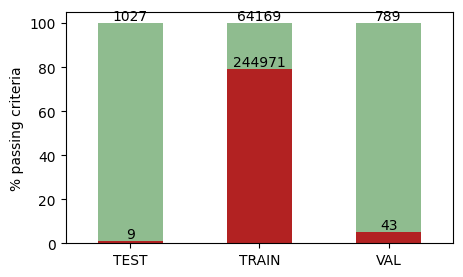

In [10]:
data = (
    plindex.drop_duplicates("system_id")
    .sort_values(by="system_pass_validation_criteria")
    .groupby(["split", "system_pass_validation_criteria"])
    .system_id.count()
    .unstack()
)
data_percentage = data.div(data.sum(axis=1), axis=0) * 100
ax = data_percentage.plot(
    kind="bar", stacked=True, figsize=(5, 3), color=["firebrick", "darkseagreen"]
)
ax.set_xticklabels(
    [label.get_text().upper() for label in ax.get_xticklabels()], rotation=0
)
ax.set_xlabel("")
ax.set_ylabel("% passing criteria")
ax.get_legend().remove()
for container, count_data in zip(ax.containers, data.values.T):
    ax.bar_label(container, labels=count_data, label_type="edge")

### Structure completeness

Related to structure quality, one aspect that is important to consider when using these structures in your training is **completeness**. While the inputs for prediction may be a protein sequence and a SMILES string, the protein-ligand complex structure that you get from the PDB may not have all the residues in the protein or all the atoms in the ligand resolved.

In [11]:
plindex = query_index(
    columns=[
        "system_id",
        "ligand_num_unresolved_heavy_atoms",
        "ligand_num_heavy_atoms",
        "system_protein_chains_num_unresolved_residues",
        "system_pocket_validation_num_unresolved_heavy_atoms",
        "system_protein_chains_total_length",
    ],
    splits=["train", "val", "test"],
)

2024-11-27 10:42:41,665 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.10s
2024-11-27 10:42:44,597 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.10s


Here we calculate the fraction of unresolved residues in the protein chains and the fraction of unresolved heavy atoms in the ligand, to see their distributions across the splits.

In [12]:
plindex[
    "system_protein_chains_total_num_unresolved_residues"
] = plindex.system_protein_chains_num_unresolved_residues.map(sum)
plindex["system_protein_chains_fraction_unresolved_residues"] = (
    plindex.system_protein_chains_total_num_unresolved_residues
    / plindex.system_protein_chains_total_length
)
plindex["ligand_fraction_unresolved_heavy_atoms"] = (
    plindex.ligand_num_unresolved_heavy_atoms / plindex.ligand_num_heavy_atoms
)

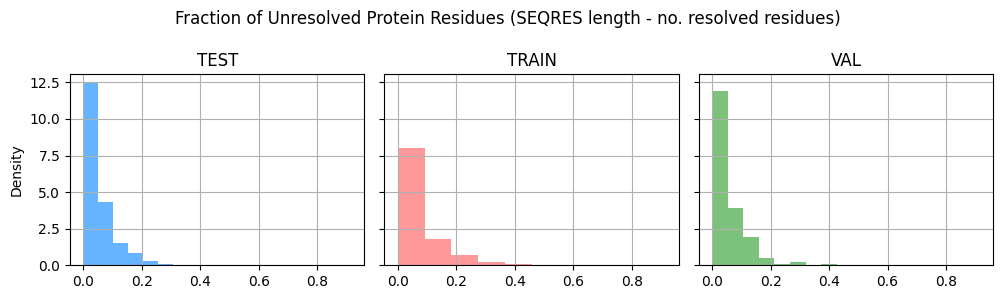

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
grouped_data = plindex.drop_duplicates("system_id").groupby("split")
split_colors = {
    "train": "#ff9999",
    "test": "#66b3ff",
    "val": "#7cc27c",
}
for i, (split, data) in enumerate(grouped_data):
    data.system_protein_chains_fraction_unresolved_residues.hist(
        ax=axes[i], density=True, color=split_colors[split]
    )
    axes[i].set_title(split.upper())
    if i == 0:
        axes[i].set_ylabel("Density")
fig.suptitle(
    "Fraction of Unresolved Protein Residues (SEQRES length - no. resolved residues)"
)
plt.tight_layout()

In [14]:
print("Percentage of ligands with no unresolved heavy atoms:")
for split in ["train", "val", "test"]:
    print(
        f'{split.capitalize()}: {100 * (plindex[plindex["split"] == split].ligand_fraction_unresolved_heavy_atoms == 0).sum() / plindex[plindex["split"] == split].shape[0]:.2f}%'
    )

Percentage of ligands with no unresolved heavy atoms:
Train: 82.34%
Val: 90.75%
Test: 93.80%


### Pocket domains

We annotated domains from different databases onto the protein chains of each system and then picked the one spanning the pocket residues of the system as the domain of the system pocket.

In [15]:
plindex = query_index(
    columns=["system_id", "system_pocket_ECOD_t_name", "system_pocket_kinase_name"],
)

2024-11-27 10:42:46,914 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s
2024-11-27 10:42:47,581 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s


In [16]:
plindex.drop_duplicates("system_id").system_pocket_ECOD_t_name.value_counts().head(10)

system_pocket_ECOD_t_name
Nucleoplasmin-like/VP (viral coat and capsid proteins)         14051
P-loop containing nucleoside triphosphate hydrolases           13463
Protein kinase                                                 11203
TIM barrels                                                     9384
Immunoglobulin/Fibronectin type III/E set domains/PapD-like     9293
NAD(P)-binding Rossmann-fold domains                            9213
Globin-like                                                     7218
Ribosomal protein L31e/gp120 outer domain                       7141
S2 subunit of coronavirus spike glycoprotein                    6701
Viral protein domain                                            6467
Name: count, dtype: int64

In [17]:
plindex.drop_duplicates("system_id").system_pocket_kinase_name.value_counts().head(10)

system_pocket_kinase_name
CDK2        494
p38a        413
EGFR        360
CK2a1       349
AurA        278
PIM1        211
ALK2        208
JAK2        191
IRAK4       186
MAPKAPK2    183
Name: count, dtype: int64

### Ligand properties

Molecular properties and annotations are calculated from the ligand SMILES strings

In [18]:
properties = [
    "ligand_molecular_weight",
    "ligand_num_rot_bonds",
    "ligand_num_rings",
    "ligand_num_hbd",
    "ligand_num_hba",
    "ligand_num_heavy_atoms",
    "ligand_crippen_clogp",
    "ligand_qed",
    "ligand_tpsa",
    "ligand_is_kinase_inhibitor",
]

In [19]:
plindex = query_index(
    columns=["system_id", "ligand_instance_chain", "ligand_unique_ccd_code"]
    + properties,
    splits=["train", "val", "test"],
    filters=[
        ("ligand_is_proper", "==", True)  # focusing on non-ion, non-artifact ligands
    ],
)
plindex.head(20)

2024-11-27 10:42:48,802 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.10s
2024-11-27 10:42:49,441 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s


,system_id,ligand_instance_chain,ligand_unique_ccd_code,ligand_molecular_weight,ligand_num_rot_bonds,ligand_num_rings,ligand_num_hbd,ligand_num_hba,ligand_num_heavy_atoms,ligand_crippen_clogp,ligand_qed,ligand_tpsa,ligand_is_kinase_inhibitor,split
0,3grt__1__1.A_2.A__1.B,1.B,FAD,785.157135,13,6,9,21,53,-2.42396,0.044261,362.93,False,train
1,3grt__1__1.A_2.A__1.C,1.C,TS2,721.288731,10,1,11,13,48,-4.04010,0.095714,313.27,False,train
2,3grt__1__1.A_2.A__2.B,2.B,FAD,785.157135,13,6,9,21,53,-2.42396,0.044261,362.93,False,train
3,3grt__1__1.A_2.A__2.C,2.C,TS2,721.288731,10,1,11,13,48,-4.04010,0.095714,313.27,False,train
4,1grx__1__1.A__1.B,1.B,GSH,307.083806,9,0,6,6,20,-2.20610,0.263437,158.82,True,train
5,6grf__1__1.A__1.D,1.D,HSR,221.089937,2,1,5,6,15,-3.07760,0.337239,119.25,False,train
6,6grf__2__1.B__1.E,1.E,HSR,221.089937,2,1,5,6,15,-3.07760,0.337239,119.25,False,train
7,3grj__2__1.B__1.I_1.L_1.Q,1.L,G14,188.058577,2,2,2,2,14,1.77490,0.754340,65.98,False,train
8,3grj__1__1.A__1.F,1.F,G14,188.058577,2,2,2,2,14,1.77490,0.754340,65.98,False,train
9,3grj__1__1.A__1.H,1.H,G14,188.058577,2,2,2,2,14,1.77490,0.754340,65.98,False,train


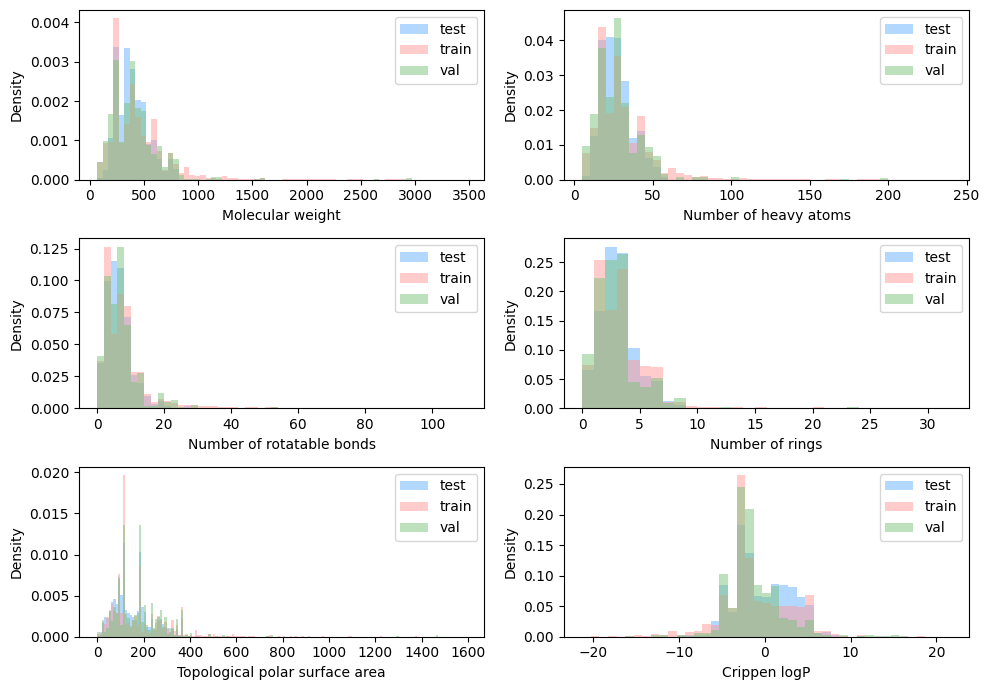

In [20]:
binwidths = {
    "ligand_molecular_weight": ("Molecular weight", 50),
    "ligand_num_heavy_atoms": ("Number of heavy atoms", 5),
    "ligand_num_rot_bonds": ("Number of rotatable bonds", 2),
    "ligand_num_rings": ("Number of rings", 1),
    "ligand_tpsa": ("Topological polar surface area", 10),
    "ligand_crippen_clogp": ("Crippen logP", 1),
}
fig, axes = plt.subplots(3, 2, figsize=(10, 7))
axes = axes.flatten()
for i, prop in enumerate(binwidths):
    ax = axes[i]
    plindex.groupby("split")[prop].plot(
        kind="hist",
        density=True,
        alpha=0.5,
        histtype="stepfilled",
        legend=True,
        ax=ax,
        color=split_colors,
        bins=np.arange(
            min(plindex[prop]),
            max(plindex[prop]) + binwidths[prop][1],
            binwidths[prop][1],
        ),
    )
    ax.set_xlabel(binwidths[prop][0])
    ax.set_ylabel("Density")
plt.tight_layout()
plt.show()

These properties were further used to categorize the ligands into different types.

In [21]:
ligand_types = [
    f"ligand_is_{x}"
    for x in [
        "lipinski",
        "covalent",
        "cofactor",
        "oligo",
        "ion",
        "fragment",
        "artifact",
    ]
]

These categories were also aggregated to the system level for easier filtering, with `system_has_<category>` as a column indicating whether any ligand in the system is of that category.

In [22]:
plindex = query_index(
    columns=["system_id", "ligand_unique_ccd_code"] + ligand_types,
    splits=["train", "val", "test"],
)

2024-11-27 10:42:51,100 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s
2024-11-27 10:42:51,746 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.11s


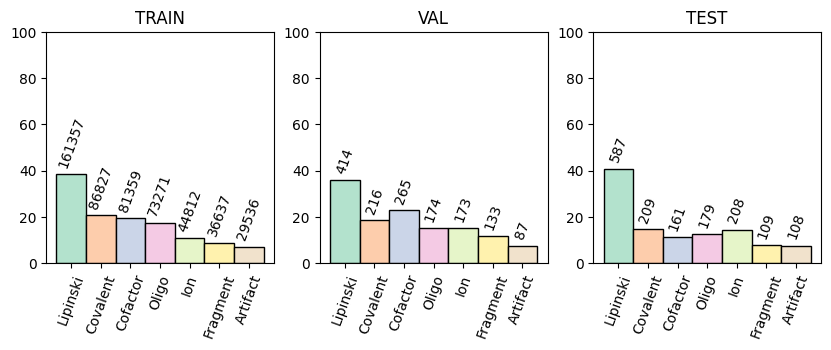

In [23]:
labels = [c.replace("ligand_is_", "").capitalize() for c in ligand_types]
bar_colors = plt.cm.Pastel2.colors
split_names = ["train", "val", "test"]
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, split in enumerate(split_names):
    ax = axes[i]
    split_data = plindex[plindex["split"] == split]
    bars = ax.bar(
        labels,
        split_data[ligand_types].mean().mul(100).to_list(),
        width=1,
        color=bar_colors,
        edgecolor="black",
        label=split,
        linewidth=1,
    )
    ax.set_xticks(np.arange(len(labels)), labels, rotation=70)
    ax.set_ylim(0, 100)
    ax.set_title(split.upper())
    counts = split_data[ligand_types].sum().to_list()
    for bar, count in zip(bars, counts):
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height() + 2,
            f"{count}",
            ha="center",
            va="bottom",
            rotation=70,
            fontsize=10,
        )

### PLI-specific properties

There are also some ligand properties that are specific to the interaction with the particular protein pocket present in the system. These include things like:
- The kinds of interactions the ligand may have with the protein, calculated using PLIP
- Experimental binding affinity, pulled from BindingDB when available
- Potential ligand-protein crystal contacts, defined as ligand-protein contacts below 5 Å which are not in the same asymmetric unit (symmetry mates) and not in the system biounit

In [24]:
pli_specific = [
    "system_fraction_atoms_with_crystal_contacts",
    "system_num_crystal_contacted_residues",
    "ligand_binding_affinity",
    "system_has_binding_affinity",
    "ligand_interactions",
    "system_num_interactions",
]

In [25]:
plindex = query_index(
    columns=["system_id"] + pli_specific,
    splits=["train", "val", "test"],
)

2024-11-27 10:42:53,069 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.08s
2024-11-27 10:42:57,550 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.13s


You could filter out systems with crystal contacts:

In [26]:
(
    plindex.drop_duplicates("system_id").system_fraction_atoms_with_crystal_contacts > 0
).sum()

34467

If your model has an additional component for predicting binding affinity, you could see how much data is available for training and evaluation:

In [27]:
plindex.drop_duplicates("system_id").groupby(
    "split"
).system_has_binding_affinity.value_counts()

split  system_has_binding_affinity
test   False                             862
       True                              174
train  False                          261204
       True                            47936
val    False                             685
       True                              147
Name: count, dtype: int64

Text(0, 0.5, 'No. of system ligands')

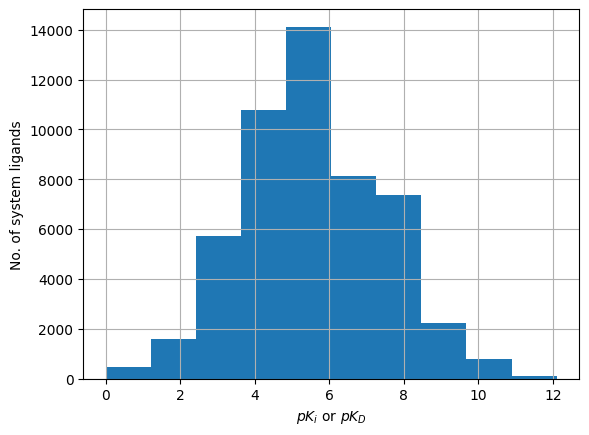

In [28]:
plindex["ligand_binding_affinity"].hist()
plt.xlabel(r"$pK_i$ or $pK_D$")
plt.ylabel("No. of system ligands")

You could even look deeper into the kinds of protein-ligand interactions present in your training data:

In [29]:
plindex.groupby("split").system_num_interactions.describe()

,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
test,1436.0,16.591226,9.886007,3.0,9.0,15.0,22.0,51.0
train,418381.0,14.448139,12.087511,0.0,5.0,12.0,21.0,722.0
val,1157.0,16.078652,10.204647,0.0,8.0,14.0,22.0,49.0


In [30]:
plindex["ligand_interactions"].values[0]

array(['1.A_36_type:hydrogen_bonds__protisdon:False__sidechain:False',
       '1.A_113_type:hydrogen_bonds__protisdon:False__sidechain:False',
       '1.A_113_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_312_type:hydrogen_bonds__protisdon:False__sidechain:False',
       '1.A_320_type:hydrogen_bonds__protisdon:False__sidechain:False',
       '1.A_322_type:hydrogen_bonds__protisdon:False__sidechain:True',
       '1.A_322_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_40_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_40_type:hydrophobic_contacts',
       '1.A_13_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_13_type:hydrogen_bonds__protisdon:True__sidechain:True',
       '1.A_11_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_35_type:hydrogen_bonds__protisdon:True__sidechain:True',
       '1.A_34_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_49_type:hydrogen_bonds__pro

## Beyond the split

Here we mainly focused on systems in the train/val/test splits as the train and val splits are the ones that can be used for training models to either participate in the PLINDER leaderboard or compare your models' performance to methods in the leaderboard.

However, PLINDER itself contains all PLI systems in the PDB (except those containing only crystallization artifacts), and you may be interested in this dataset as a whole. This can be queried with the `splits=["*"]` option.

In [31]:
plindex = query_index(
    columns=[
        "system_id",
        "entry_pdb_id",
        "system_num_protein_chains",
        "system_num_ligand_chains",
    ]
    + ligand_types,
    splits=["*"],
)
print("No. ligands:", len(plindex))
print("No. systems:", plindex.system_id.nunique())
print("No. PDB entries:", plindex.entry_pdb_id.nunique())

2024-11-27 10:42:59,362 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.15s
2024-11-27 10:43:00,060 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s


No. ligands: 1357906
No. systems: 990260
No. PDB entries: 143800


system_num_protein_chains
1     857629
2     312129
3      73237
4      19875
30     14122
       ...  
72        72
64        64
53        61
52        52
29        30
Name: count, Length: 74, dtype: int64
system_num_ligand_chains
1     809509
2     248916
3     107613
4      45856
5      17065
       ...  
84        84
39        78
74        74
67        67
46        46
Name: count, Length: 238, dtype: int64


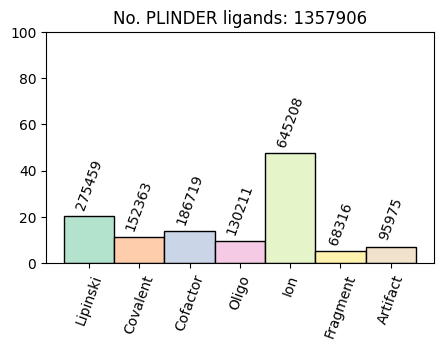

In [32]:
fig, ax = plt.subplots(figsize=(5, 3))
bars = ax.bar(
    labels,
    plindex[ligand_types].mean().mul(100).to_list(),
    width=1,
    color=bar_colors,
    edgecolor="black",
    label=split,
    linewidth=1,
)
ax.set_xticks(np.arange(len(labels)), labels, rotation=70)
ax.set_ylim(0, 100)
ax.set_title(f"No. PLINDER ligands: {len(plindex)}")
counts = plindex[ligand_types].sum().to_list()
for bar, count in zip(bars, counts):
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height() + 2,
        f"{count}",
        ha="center",
        va="bottom",
        rotation=70,
        fontsize=10,
    )

print(plindex.system_num_protein_chains.value_counts())
print(plindex.system_num_ligand_chains.value_counts())

When looking at distributions across the entire dataset, you'll notice that there are quite a lot of ion systems, as well as systems with more than 5 protein or ligand chains.

:::{note} While we provide annotations for all systems, those which are not in the train and val splits may not be used for training models to participate in the MLSB PLINDER leaderboard. :::

## Similarity clusters

Similarity between two protein-ligand complexes can occur at various levels, including protein sequence, structural features, binding pocket characteristics, or ligand and interaction properties. We calculated a comprehensive set of similarity metrics to cover every combination of these dimensions — from identical systems, where the protein, pocket, interactions and ligand are the same, to systems that differ across all levels.

The entire set of similarity metrics is described [here](https://plinder-org.github.io/plinder/dataset.html#clusters-clusters), and they were calculated across all pairs of systems having a Foldseek or MMseqs alignment. We then used graph clustering to group systems into clusters based on their similarity with a specific **_metric_** and **_threshold_**. There are three types of clusters available: strongly connected graph components (**_strong component_**), weakly connected graph components (**_weak component_**), and communities detected using asynchronous label propagation (**_community_**).

We can load the similarity clusters assigned to each system for different metrics, thresholds, and clustering types.

These cluster labels can be used in many ways with the annotations.

### Example: ATP-binding pockets

For example, maybe you are interested in seeing how many different kinds of ATP-binding pockets we have. First, let's find all the analogs of ATP. We can do this by finding the 95% ECFP4 tanimoto similarity component of ATP and then getting the CCD codes of all the ligands in the same cluster:

In [33]:
ligand_cluster_column = "tanimoto_similarity_max__95__strong__component"
atp_ligand_cluster = query_index(
    columns=[
        ligand_cluster_column,
    ],
    filters=[
        ("ligand_unique_ccd_code", "==", "ATP"),
        ("system_num_ligand_chains", "==", 1),
    ],
)[ligand_cluster_column].values[0]

atp_analogs = query_index(
    columns=[
        "system_id",
        "entry_pdb_id",
        "ligand_unique_ccd_code",
        "ligand_rdkit_canonical_smiles",
    ],
    filters=[
        (ligand_cluster_column, "==", atp_ligand_cluster),
        ("system_num_ligand_chains", "==", 1),
    ],
).drop_duplicates("ligand_unique_ccd_code")
atp_analogs_code_set = set(atp_analogs.ligand_unique_ccd_code.unique())
atp_analogs_code_set

2024-11-27 10:43:01,723 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s
2024-11-27 10:43:02,044 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s
2024-11-27 10:43:02,532 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s
2024-11-27 10:43:02,870 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.08s


{'5FA', 'ADP', 'AQP', 'ATP', 'ZF9', 'ZSF'}

Let's see how they look

In [34]:
grid = mols2grid.MolGrid(atp_analogs, smiles_col="ligand_rdkit_canonical_smiles")
grid.display(subset=["ligand_unique_ccd_code", "img"])

MolGridWidget()

Now we can get the pocket clusters of all systems containing ATP analogs. Here we're using `pocket_qcov__50__weak__component`, meaning a system within a cluster has some other system in that cluster with which it shares at least 50% of pocket residues when aligned.

In [35]:
pocket_cluster_column = "pocket_qcov__50__weak__component"
plindex = query_index(
    columns=[
        "system_id",
        "entry_pdb_id",
        "entry_release_date",
        pocket_cluster_column,
        "system_pocket_ECOD_t_name",
    ],
    filters=[
        (
            "ligand_unique_ccd_code",
            "in",
            atp_analogs_code_set,
        ),  # only ATP-binding systems
        ("ligand_num_interactions", ">", 2),  # with >2 interactions with ATP
        ("system_num_ligand_chains", "==", 1),  # and ATP is the only ligand
    ],
)

2024-11-27 10:43:03,497 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s
2024-11-27 10:43:03,869 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.08s


In [36]:
(
    "No. systems:",
    plindex.system_id.nunique(),
    "No. PDB entries:",
    plindex.entry_pdb_id.nunique(),
    "No. clusters:",
    plindex[pocket_cluster_column].nunique(),
)

('No. systems:', 5409, 'No. PDB entries:', 1484, 'No. clusters:', 154)

In [37]:
plindex[pocket_cluster_column].value_counts().head(10)

pocket_qcov__50__weak__component
c0      3562
c123     260
c11      259
c206     146
c204     141
c132      80
c391      75
c95       73
c205      58
c319      58
Name: count, dtype: int64

When we look at the ECOD topology names of the cluster "c11" for example, we see that these systems are GroEL equatorial domain-like domains. Interestingly, 7 systems from 2 different PDB entries don't have ECOD annotations yet as they were recently released, but are indeed [the same domain](https://doi.org/10.1038/s41467-024-45242-x).

In [38]:
plindex[plindex[pocket_cluster_column] == "c11"].system_pocket_ECOD_t_name.value_counts(
    dropna=False
)

system_pocket_ECOD_t_name
GroEL equatorial domain-like    252
None                              7
Name: count, dtype: int64

In [39]:
plindex[
    (plindex[pocket_cluster_column] == "c11")
    & (plindex["system_pocket_ECOD_t_name"].isna())
].drop_duplicates("entry_pdb_id")

,system_id,entry_pdb_id,entry_release_date,pocket_qcov__50__weak__component,system_pocket_ECOD_t_name,split
527,8i6j__1__1.B__1.C,8i6j,2023-01-28,c11,None,train
2756,8hki__1__1.I__1.Q,8hki,2022-11-27,c11,None,train


In [40]:
plindex[plindex["system_pocket_ECOD_t_name"].isna()]["entry_pdb_id"].nunique()

290

### Example: Diversity sampling

The `pli_unique_qcov__50__community` column clusters systems such that the protein and ligand make similar interactions with the pocket. This clustering combines protein sequence and structural similarity (needed to obtain the pocket alignment), as well as the ligand-pocket interactions, making it a good proxy for unique kinds of binding present in the dataset.

Here's an example of how one might use `torch.utils.data.WeightedRandomSampler` to sample training systems based on their PLI community cluster.

In [41]:
from torch.utils.data import WeightedRandomSampler

cluster_column = "pli_unique_qcov__50__community"

# Get train systems and their cluster labels
plindex = query_index(
    columns=["system_id", "entry_pdb_id", cluster_column], splits=["train"]
).drop_duplicates("system_id")

# Add the number of systems in each cluster to the dataframe
plindex = plindex.merge(
    plindex[cluster_column].value_counts().rename("cluster_num_systems"),
    left_on=cluster_column,
    right_index=True,
).reset_index(drop=True)

# Add the number of PDB entries in each cluster to the dataframe
plindex = plindex.merge(
    plindex.drop_duplicates("entry_pdb_id")[cluster_column]
    .value_counts()
    .rename("cluster_num_entries"),
    left_on=cluster_column,
    right_index=True,
).reset_index(drop=True)

# Ignore clusters with only one PDB entry
sample_from = plindex[plindex["cluster_num_entries"] > 1].reset_index(drop=True)

# Calculate the weight for each cluster
cluster_weights = 1.0 / sample_from.cluster_num_systems.values

# Create a WeightedRandomSampler and sample systems from the train set
sampler = WeightedRandomSampler(
    weights=cluster_weights, num_samples=len(cluster_weights)
)
sampled_indices = list(sampler)
sampled_plindex = (
    sample_from.iloc[sampled_indices]
    .reset_index(drop=True)
    .drop(columns=["cluster_num_systems", "cluster_num_entries"])
)

# Add the number of sampled systems in each cluster to the sampled dataframe
sampled_plindex = sampled_plindex.merge(
    sampled_plindex[cluster_column].value_counts().rename("cluster_num_systems"),
    left_on=cluster_column,
    right_index=True,
).reset_index(drop=True)

# Add the number of sampled PDB entries in each cluster to the sampled dataframe
sampled_plindex = sampled_plindex.merge(
    sampled_plindex.drop_duplicates("entry_pdb_id")[cluster_column]
    .value_counts()
    .rename("cluster_num_entries"),
    left_on=cluster_column,
    right_index=True,
)

2024-11-27 10:43:05,931 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.10s
2024-11-27 10:43:06,564 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.09s


In [42]:
print("No. of original systems: ", sample_from.system_id.nunique())
print("No. of nonredundant sampled systems: ", sampled_plindex.system_id.nunique())
print("No. of original clusters: ", sample_from[cluster_column].nunique())
print("No. of sampled clusters: ", sampled_plindex[cluster_column].nunique())

No. of original systems:  259772
No. of nonredundant sampled systems:  57490
No. of original clusters:  2723
No. of sampled clusters:  2719


Let's see how the sampling process has affected the distribution of cluster sizes.

Text(0, 0.5, '# Clusters')

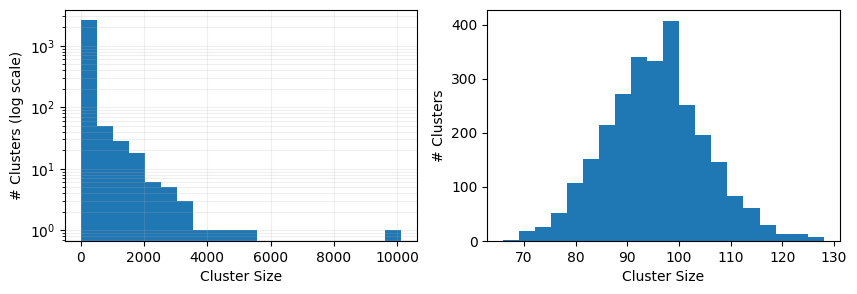

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

cluster_sizes = (
    sample_from.drop_duplicates(cluster_column)
    .cluster_num_systems.value_counts()
    .sort_index()
)
ax[0].hist(cluster_sizes.index, weights=cluster_sizes.values, bins=20, log=True)
ax[0].set_xlabel("Cluster Size")
ax[0].set_ylabel("# Clusters (log scale)")
ax[0].grid(True, which="both", ls="-", alpha=0.2)

cluster_sizes = (
    sampled_plindex.drop_duplicates(cluster_column)
    .cluster_num_systems.value_counts()
    .sort_index()
)
ax[1].hist(cluster_sizes.index, weights=cluster_sizes.values, bins=20, log=False)
ax[1].set_xlabel("Cluster Size")
ax[1].set_ylabel("# Clusters")